In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import os
import pickle

Loading the DataSets :
- We are using data sets downloaded and stored in inputs folder from Smart.de Website
- Generation Data - All the data of Energy produced from different type of power plants in year 2024 in the time scale of 1 hour 
- Consumption Data - contains the grid load for each hour of the year 2024
- Day-ahead Prices - contains the day ahead prices in each hour of the year 2024
- All these data sets are loaded and merged together in a single dataframe to use it further

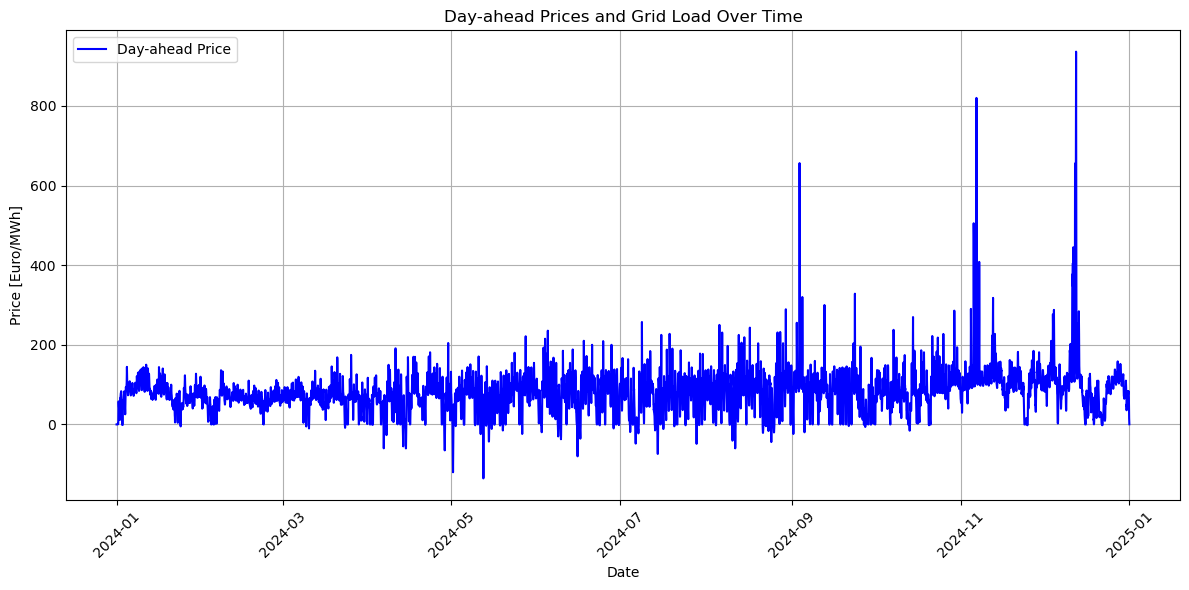

Index(['Start date', 'day_ahead_price [Euro/MWh]', 'grid_load [MWh]',
       'Biomass [MWh]', 'Hydropower [MWh]', 'Wind offshore [MWh]',
       'Wind onshore [MWh]', 'Photovoltaics [MWh]', 'Other renewable [MWh]',
       'Lignite [MWh]', 'Hard coal [MWh]', 'Fossil gas [MWh]',
       'Hydro pumped storage [MWh]', 'Other conventional [MWh]'],
      dtype='object')


In [2]:
# Load the datasets
generation_data = pd.read_csv('inputs/Actual_generation_2024.csv', sep=';')
consumption_data = pd.read_csv('inputs/Actual_consumption_2024.csv', sep=';')
day_ahead_data = pd.read_csv('inputs/Day-ahead_prices_2024.csv', sep=';')

# Rename columns for clarity
cols_to_rename = [
    'Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
    'Photovoltaics', 'Fossil gas', 'Other renewable', 'Hard coal',
    'Lignite', 'Hydro pumped storage', 'Other conventional']
generation_data.rename(columns={
    f"{col} [MWh] Calculated resolutions": f"{col} [MWh]"
    for col in cols_to_rename
}, inplace=True)

generation_data.drop(columns=['Start date', 'End date','Nuclear [MWh] Calculated resolutions'], inplace=True)

# Merge the datasets based on the 'Start date' column
data = pd.DataFrame()
data['Start date'] = pd.to_datetime(consumption_data['Start date'], format='%b %d, %Y %I:%M %p')
data['day_ahead_price [Euro/MWh]'] = day_ahead_data['Germany/Luxembourg [€/MWh] Original resolutions']
data['grid_load [MWh]'] = consumption_data['grid load [MWh] Calculated resolutions']
data = pd.concat([data, generation_data], axis=1)

# Plot the data 
plt.figure(figsize=(12, 6))
plt.plot(data['Start date'], data['day_ahead_price [Euro/MWh]'], label='Day-ahead Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price [Euro/MWh]')
plt.title('Day-ahead Prices and Grid Load Over Time')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print(data.columns)  # Display the DataFrame

In [3]:
# Convert specific columns to float
cols_to_convert = data.columns.drop('Start date')
data[cols_to_convert] = data[cols_to_convert].replace('-', 0, regex=True)
data[cols_to_convert] = data[cols_to_convert].replace(',', '', regex=True).astype(float)
# Save the merged dataset to a CSV file
data.to_csv('inputs/merged_data.csv', index=False)
data.columns = data.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)

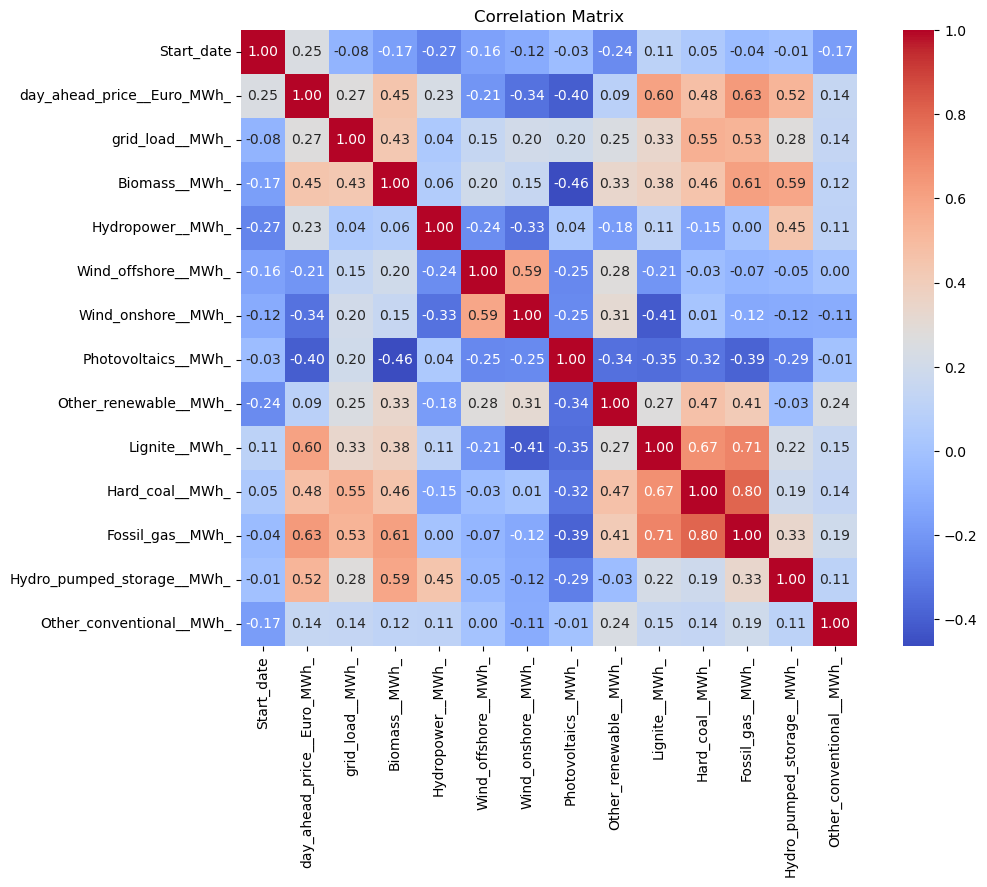

Selected Features:
 Index(['Fossil_gas__MWh_', 'Lignite__MWh_', 'Hydro_pumped_storage__MWh_',
       'Hard_coal__MWh_', 'Biomass__MWh_', 'Photovoltaics__MWh_',
       'Wind_onshore__MWh_'],
      dtype='object')


In [ ]:
# Create a Correlation Matrix
correlation_matrix = data.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Select top five features and target variable
no_of_features = 7
top_features = correlation_matrix['day_ahead_price__Euro_MWh_'].abs().nlargest(no_of_features+1).index
top_features = top_features.drop('Start_date') if 'Start_date' in top_features else top_features
X = data[top_features.drop('day_ahead_price__Euro_MWh_')]
y = data['day_ahead_price__Euro_MWh_']
print("Selected Features:\n", X.columns)

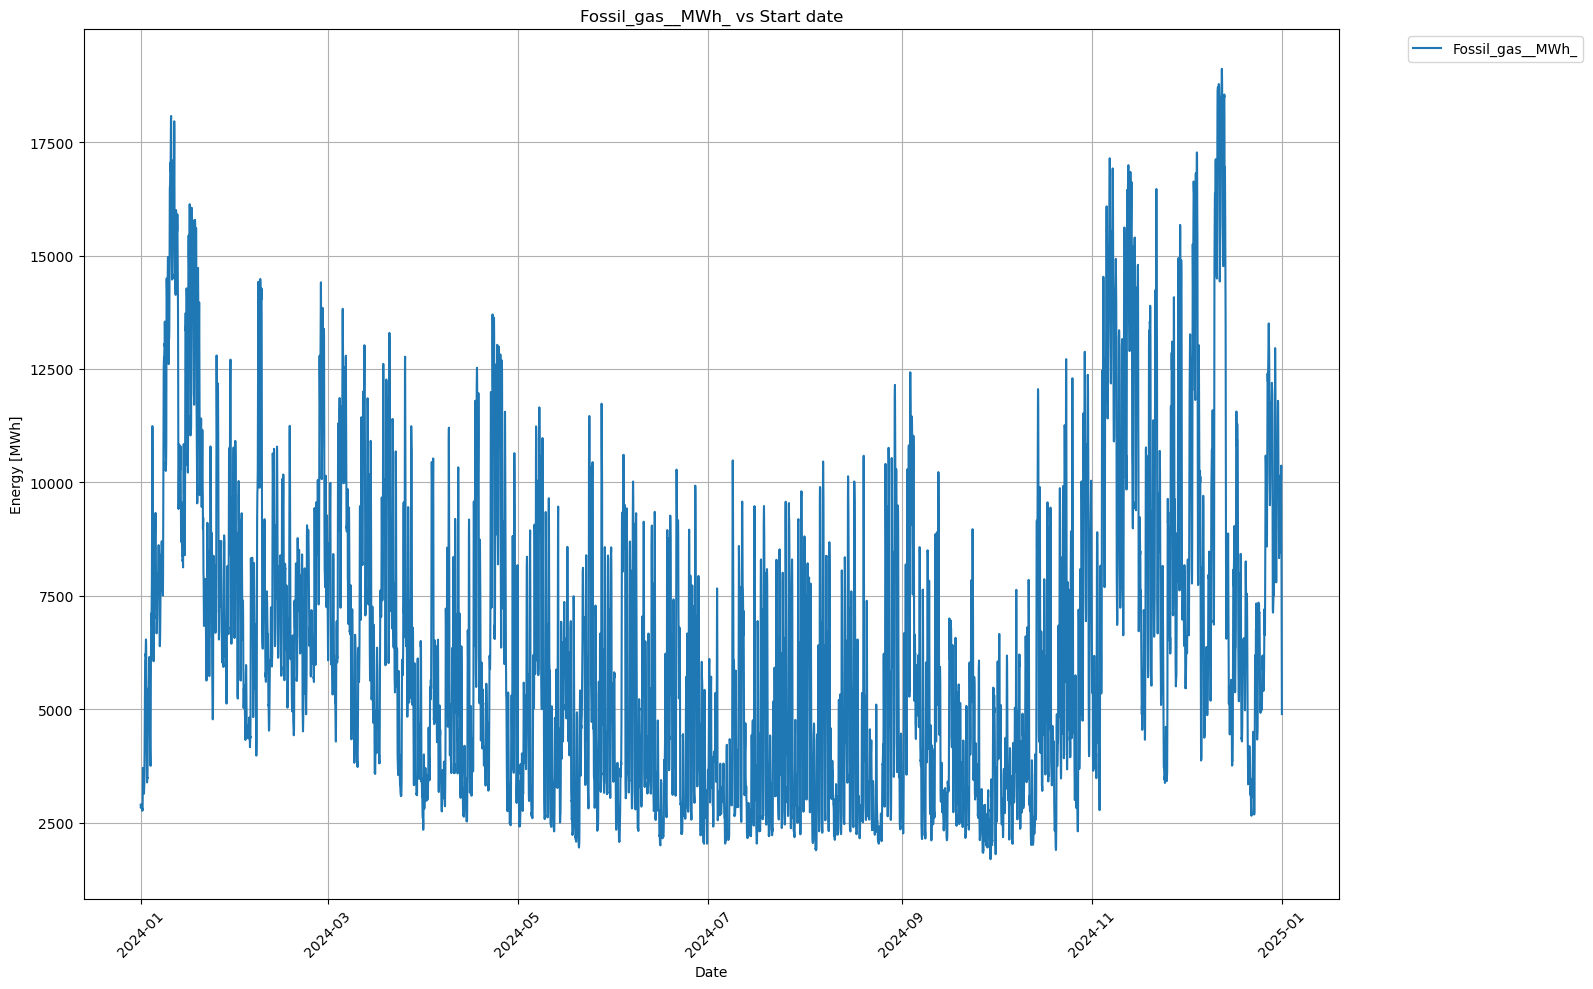

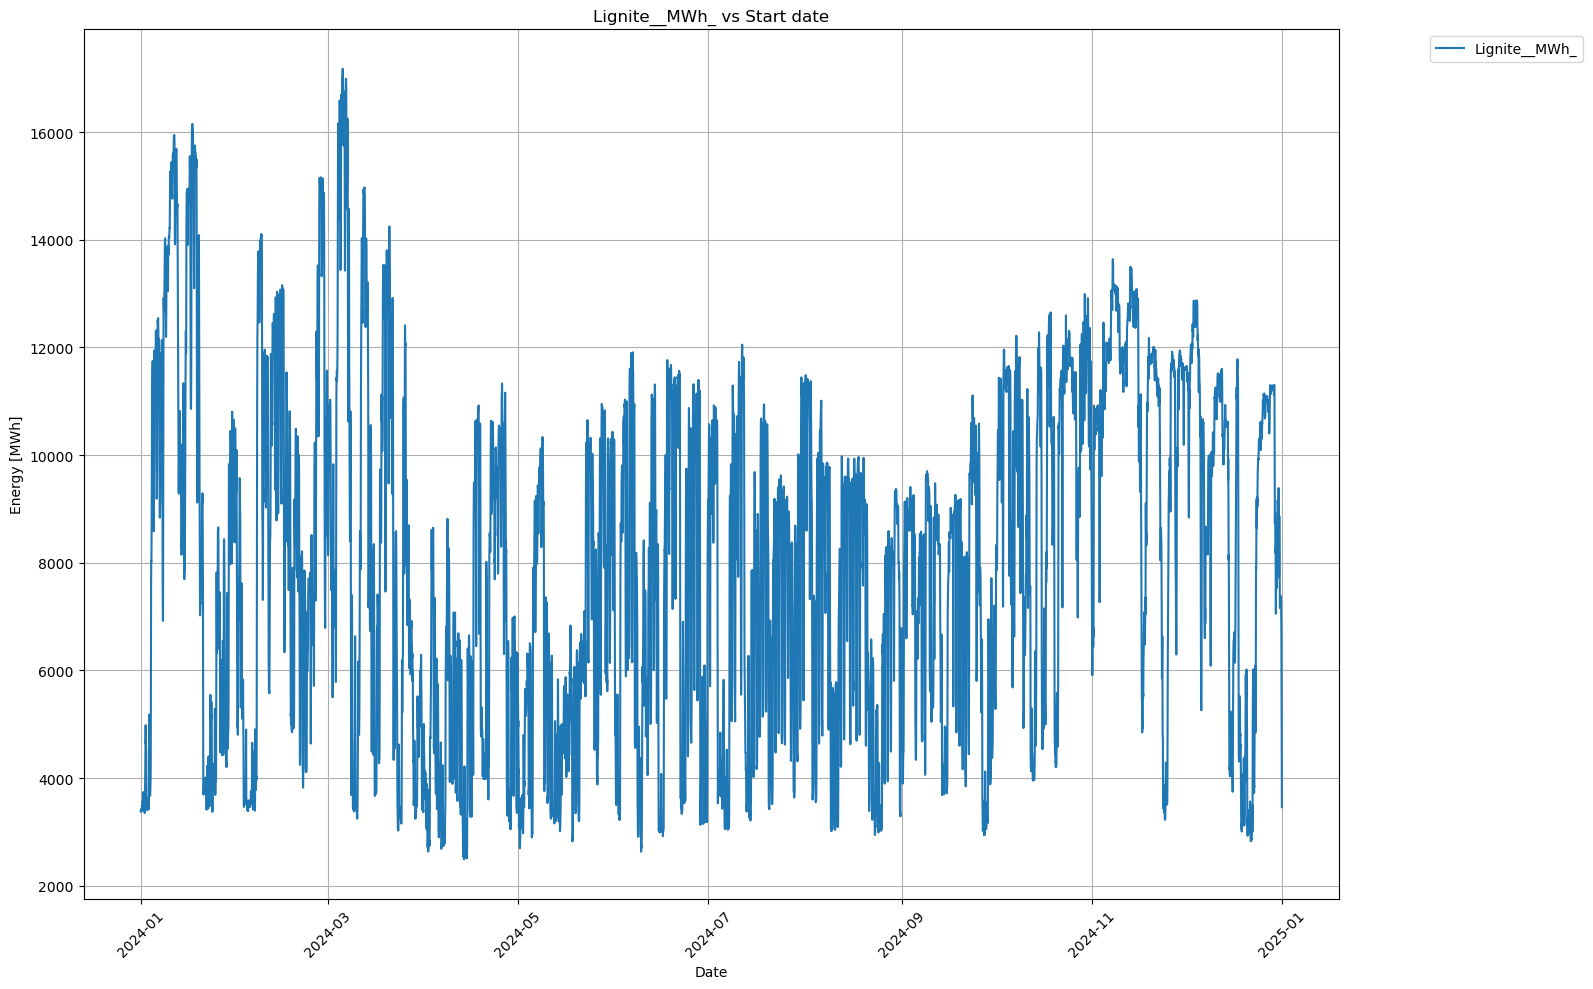

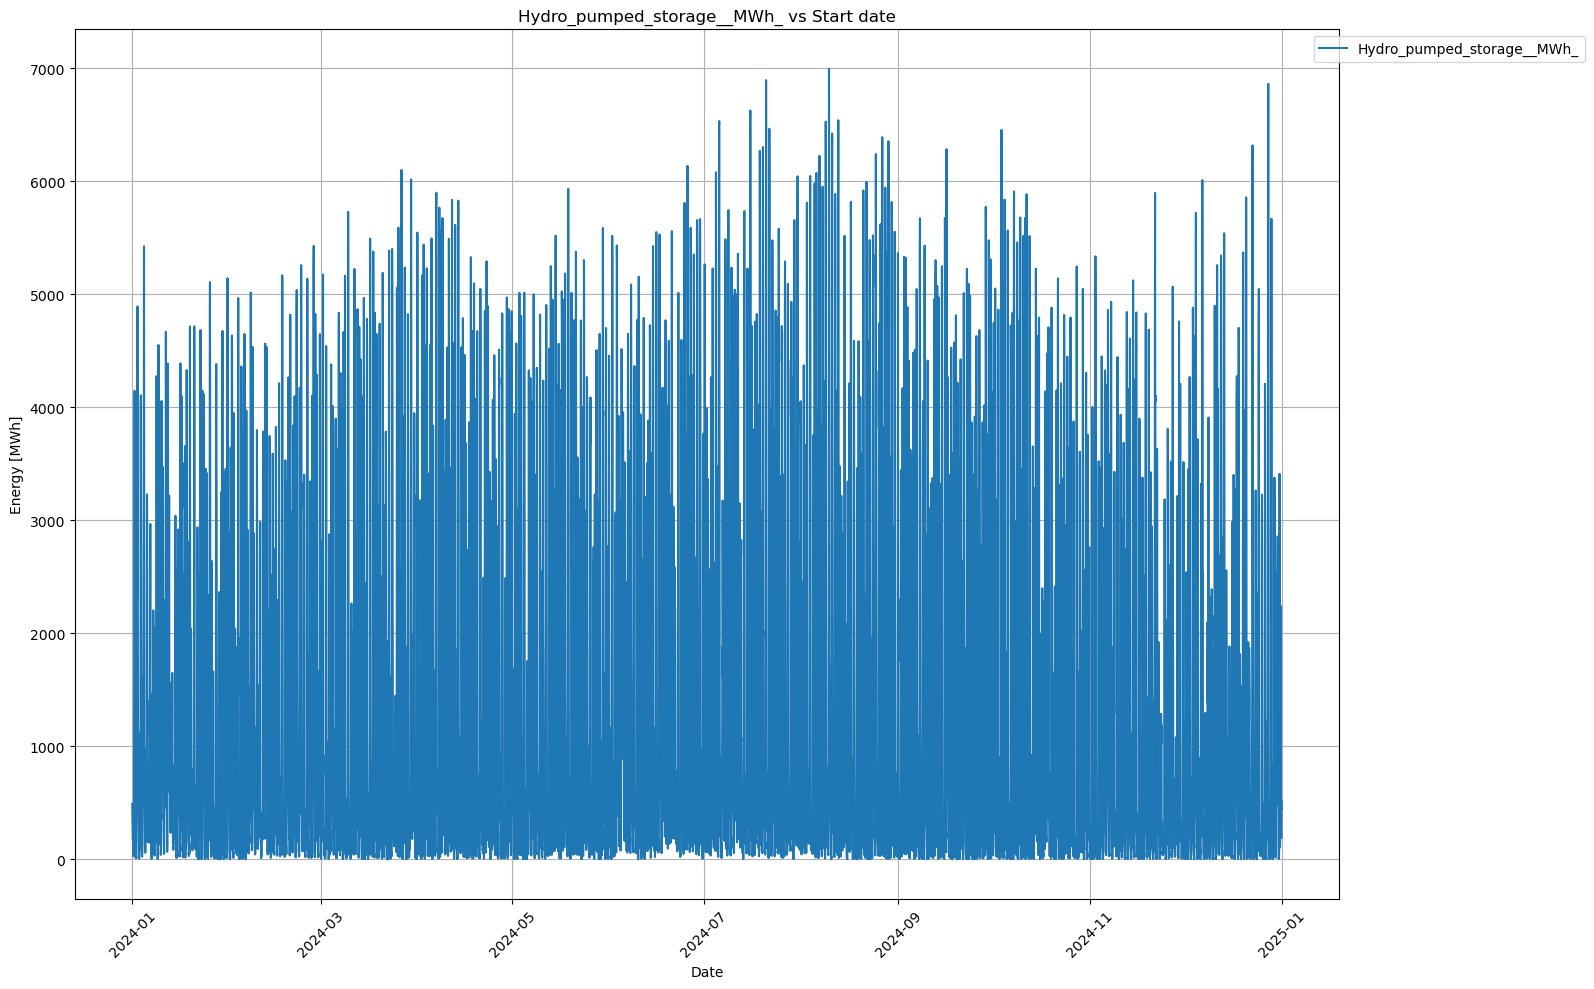

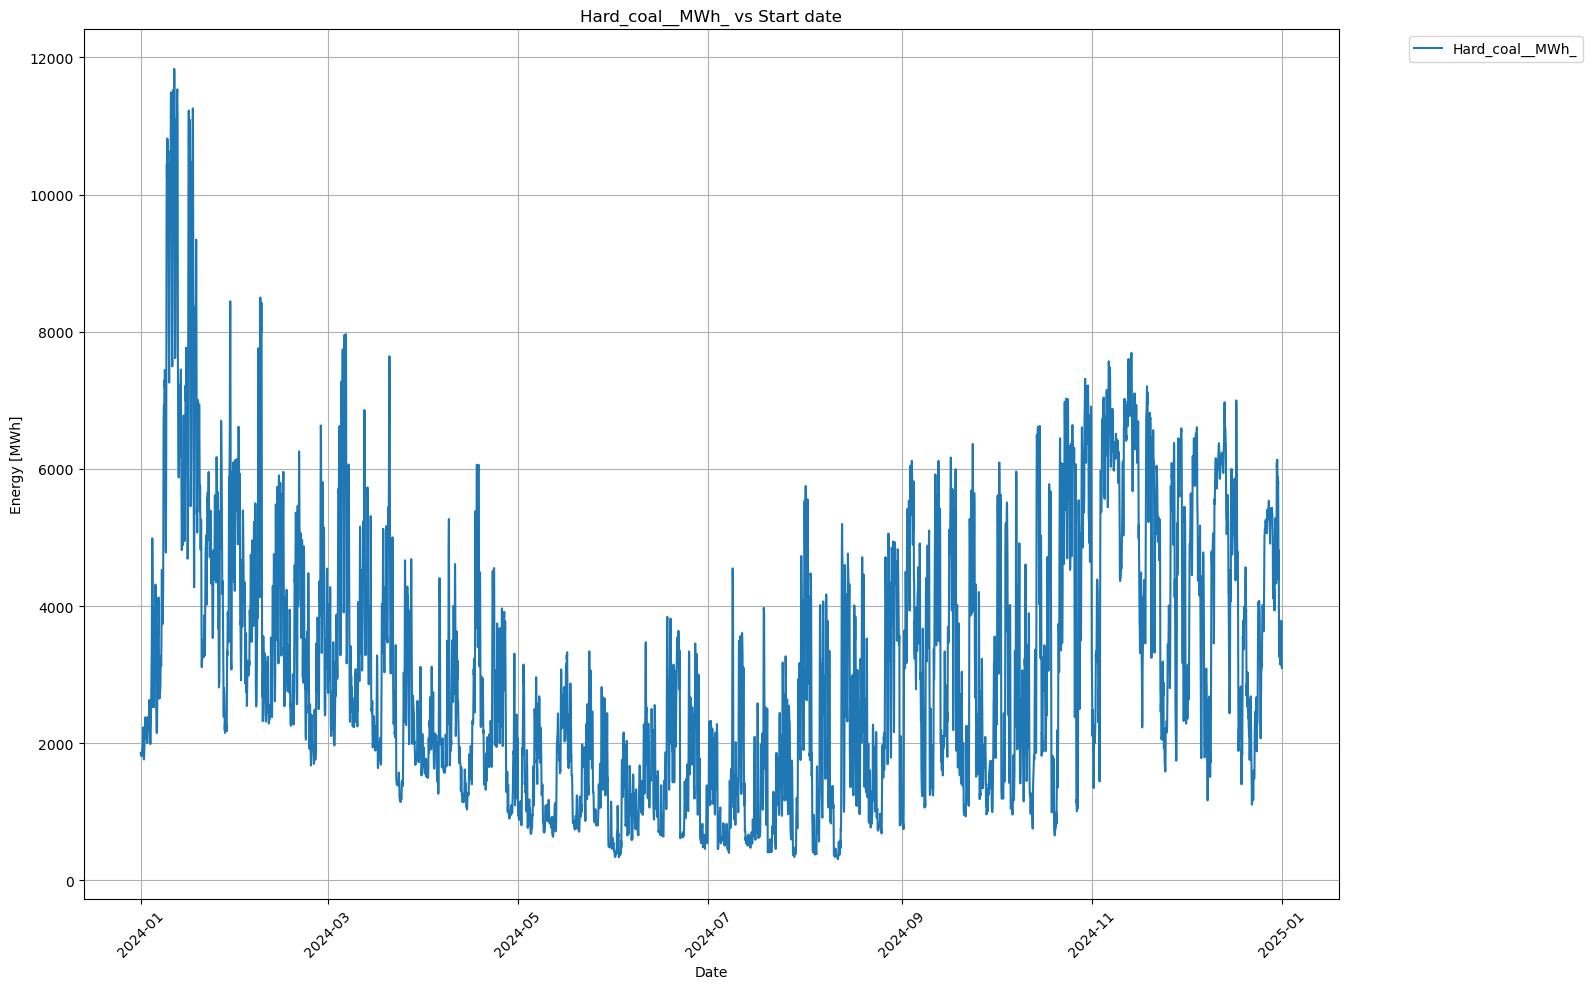

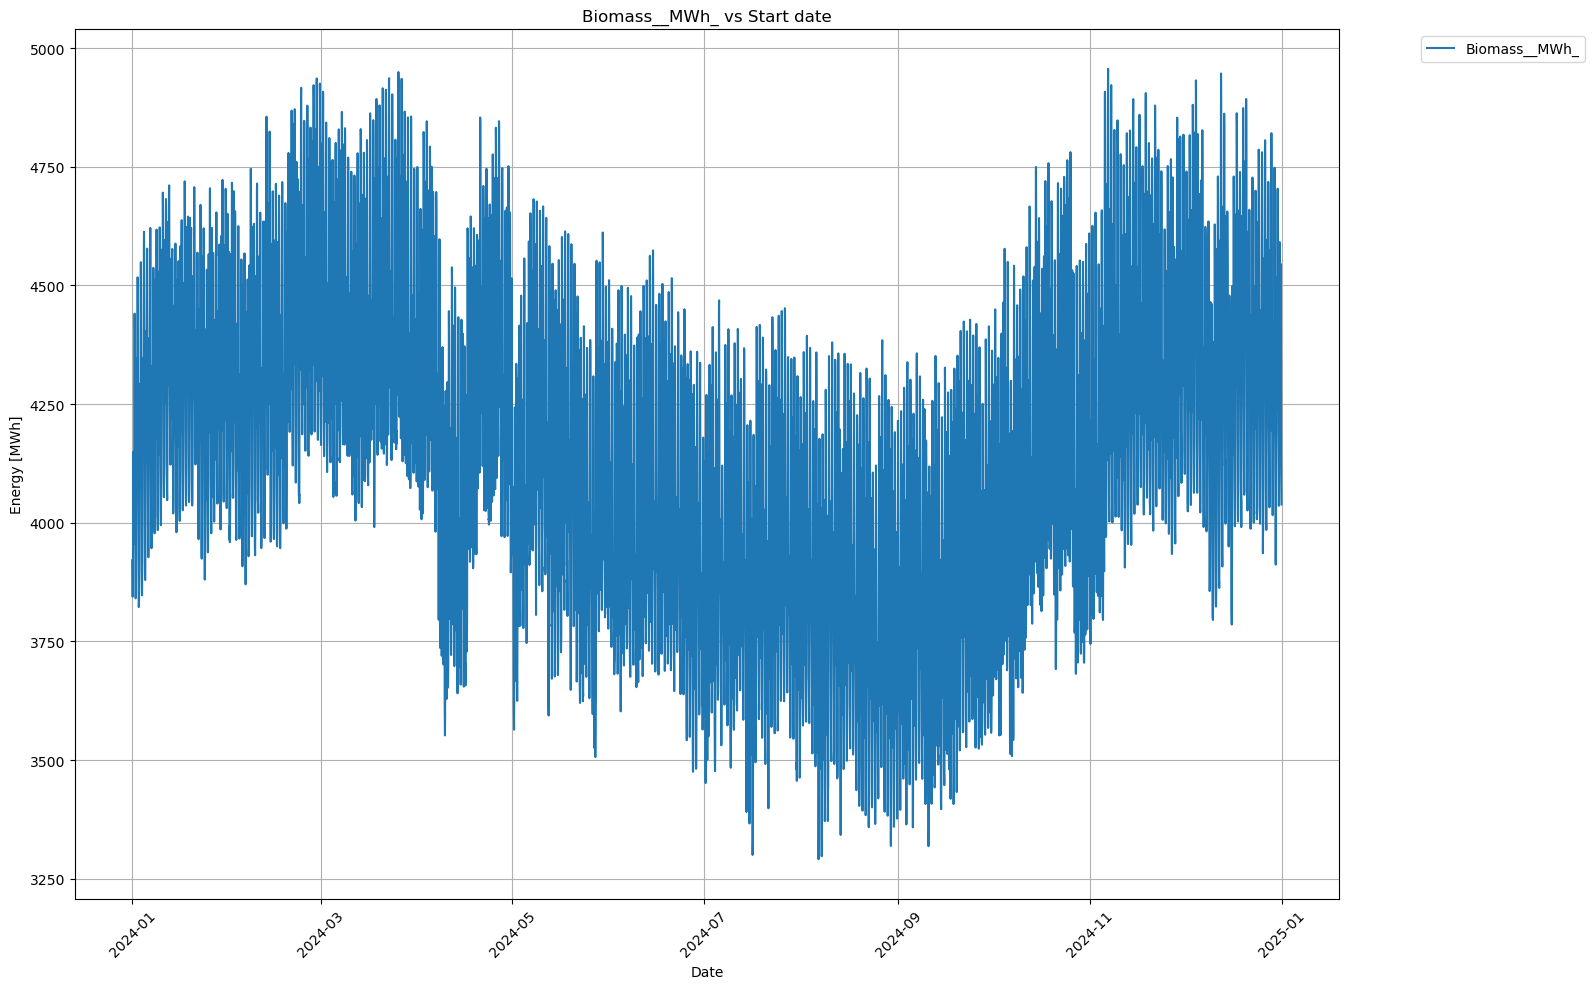

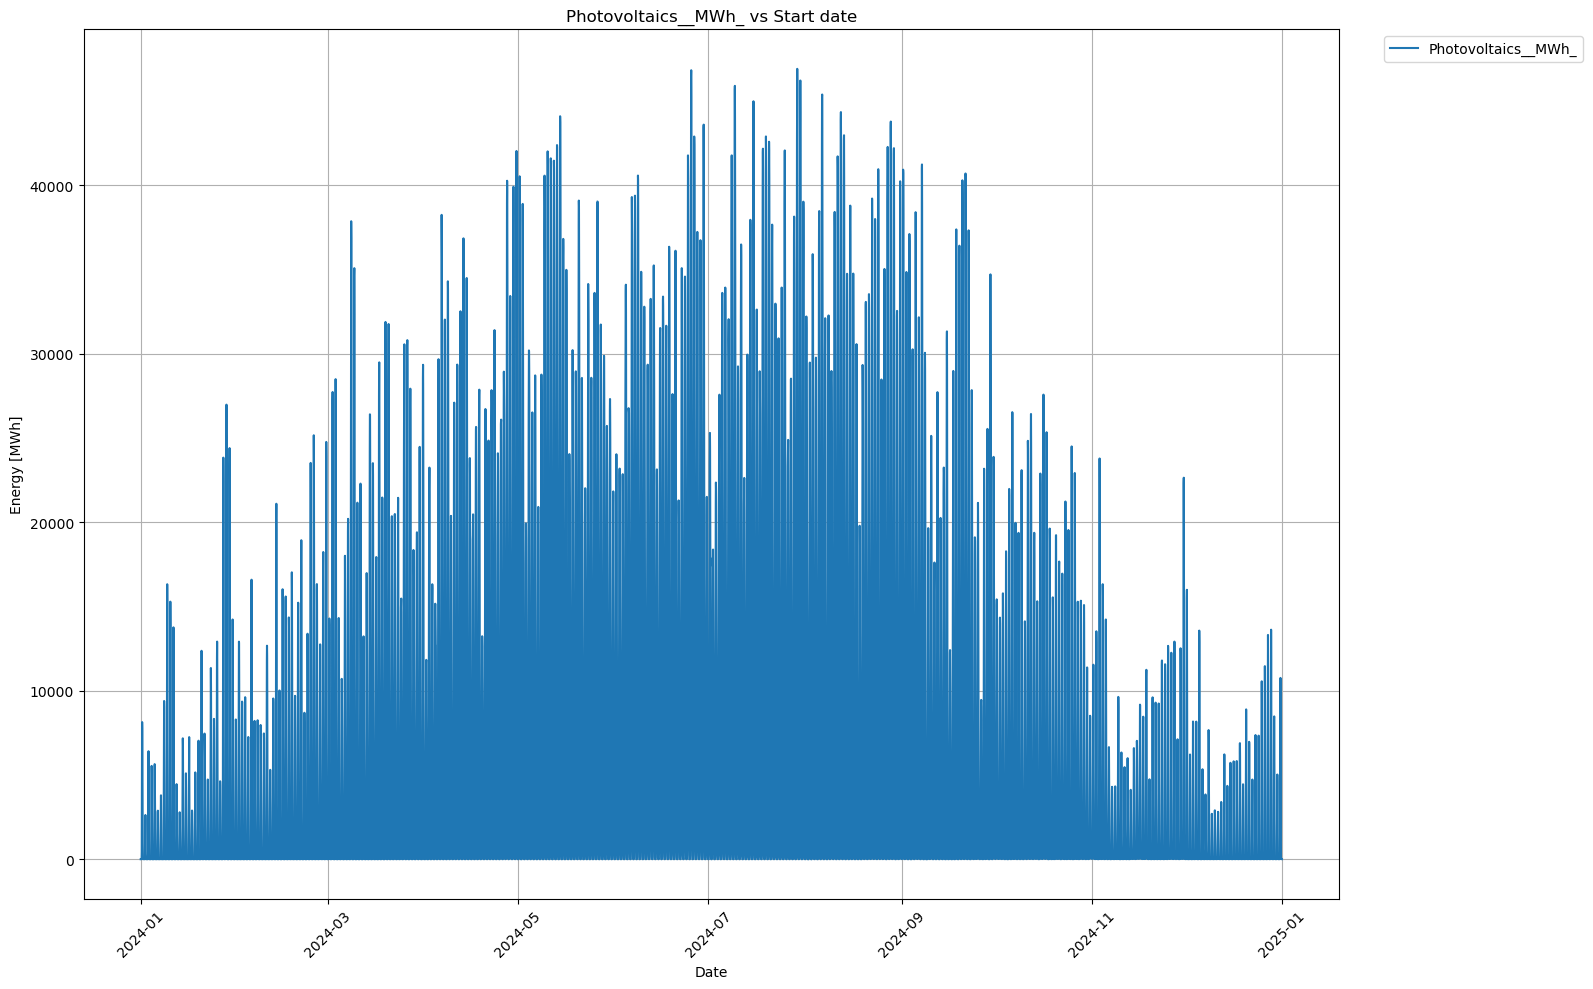

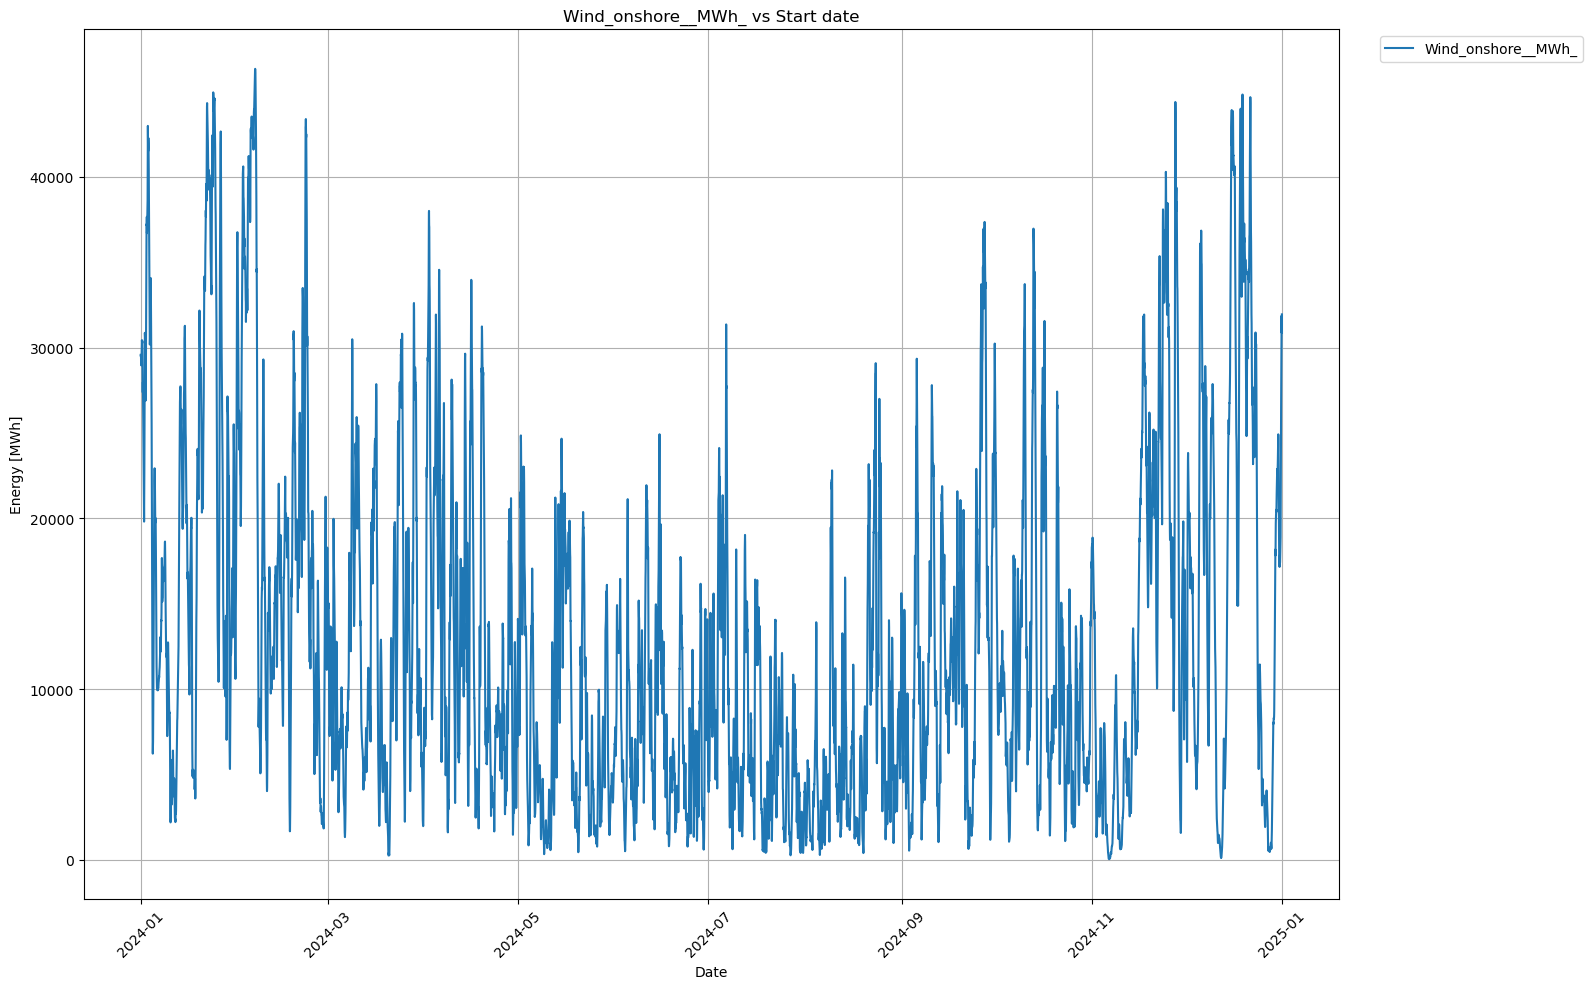

In [ ]:
# Plot top selected features against 'Start date'
top_features_to_plot = top_features.drop('day_ahead_price__Euro_MWh_') if 'day_ahead_price__Euro_MWh_' in top_features else top_features

for feature in top_features_to_plot:
    plt.figure(figsize=(16, 10))
    plt.plot(data['Start_date'], data[feature], label=feature)
    plt.xlabel('Date')
    plt.ylabel('Energy [MWh]')
    plt.title( feature + ' vs Start date')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

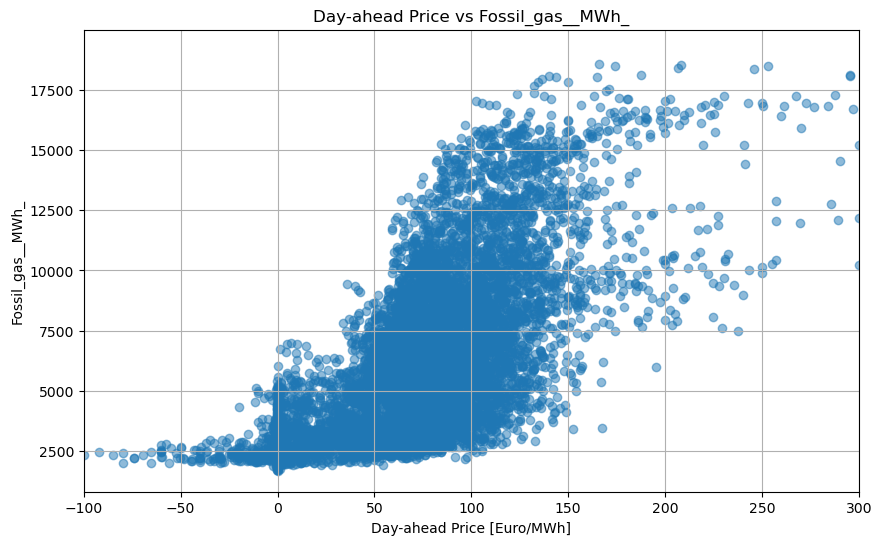

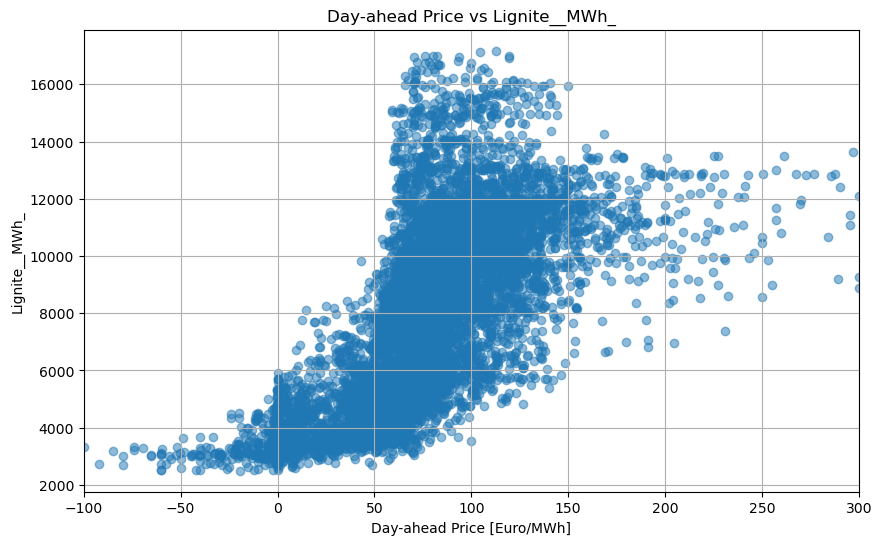

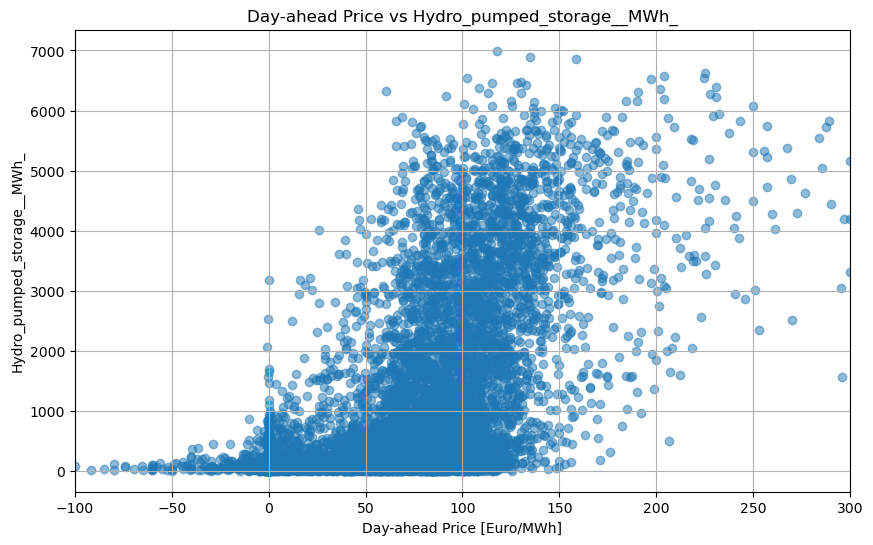

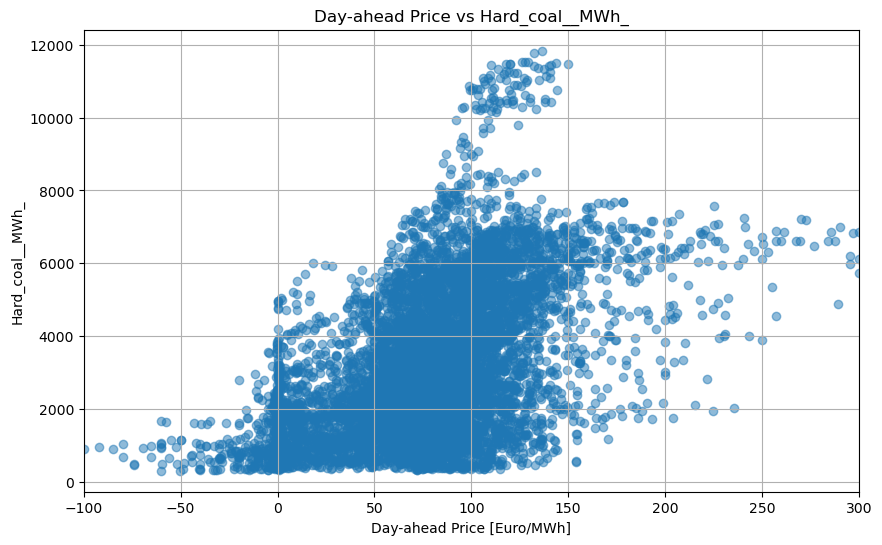

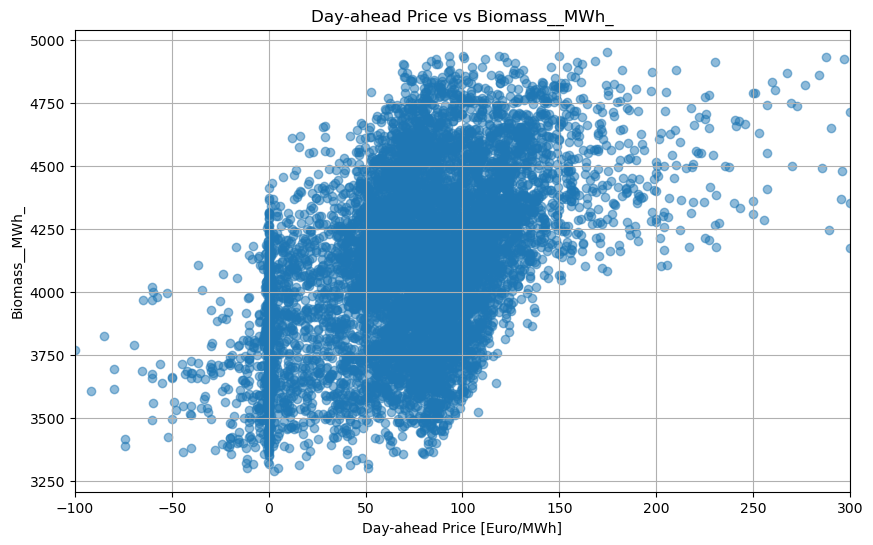

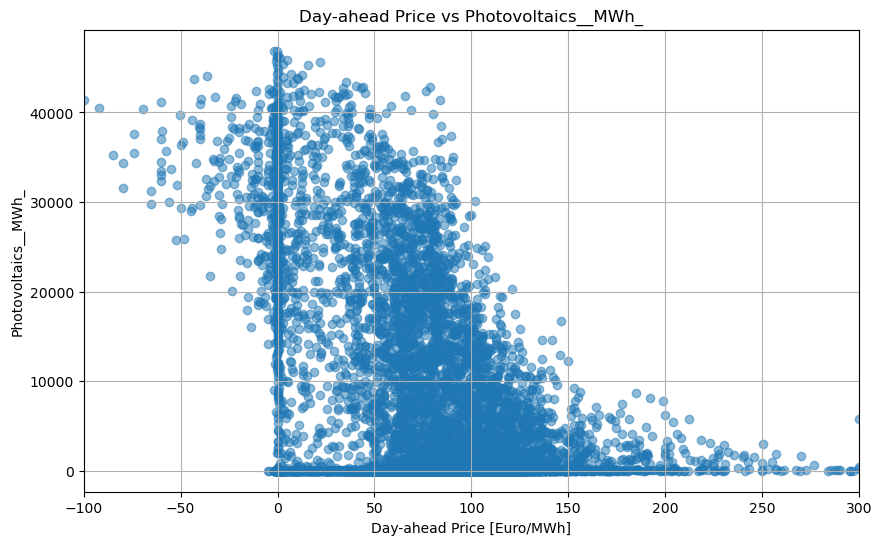

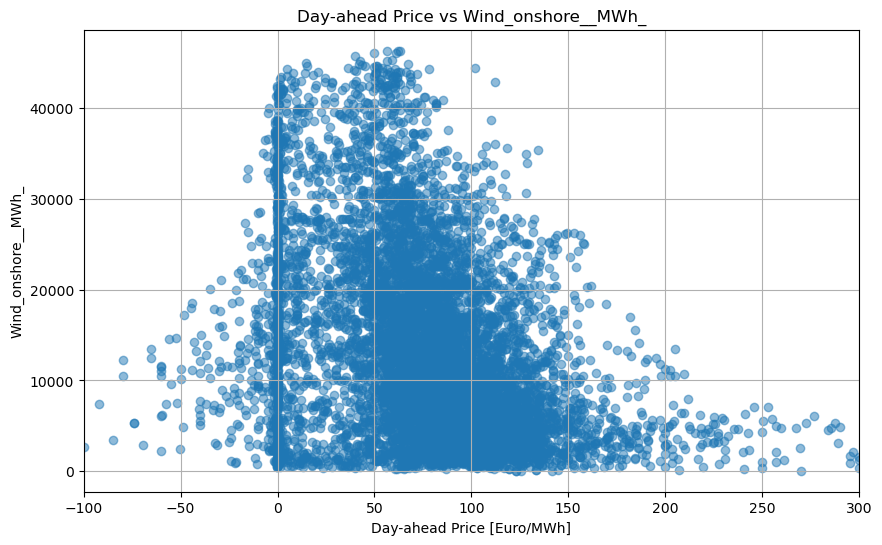

In [6]:
# Plot the selected features (Y axis) against the target variable (day-ahead price)
for feature in X.columns:
    plt.figure(figsize=(10, 6)),
    plt.scatter(y, X[feature], alpha=0.5),
    plt.title(f'Day-ahead Price vs {feature}'),
    plt.xlabel('Day-ahead Price [Euro/MWh]'),
    plt.xlim(-100, 300)
    plt.ylabel(feature),
    plt.grid(),
    plt.show()

In [7]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate error metrics
def calculate_error_metrics(y_true, y_pred):
    """Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between true and predicted values."""
    if len(y_true) == 0 or len(y_pred) == 0:
        return {'MAE': np.nan, 'RMSE': np.nan}
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   
    return {
        'MAE': mae.round(2),
        'RMSE': rmse.round(2)
    }

# Function to display the error metrics
def display_error_metrics(y_train, y_train_pred, y_test, y_test_pred, title, set_name = "Test"):
    """Display the error metrics for training and testing sets."""
    print(f"{title} Error Metrics:")
    print("Training Data Error :", calculate_error_metrics(y_train, y_train_pred))
    print(set_name +" Error :", calculate_error_metrics(y_test, y_test_pred))

In [ ]:
# Muliple Linear Regression Model
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Print the RMSE and MAE for the training set
y_train_pred = linear_model.predict(X_train)
y_val_pred = linear_model.predict(X_val)
display_error_metrics(y_train, y_train_pred, y_val, y_val_pred, "Linear Regression", "Validation")
y_test_pred = linear_model.predict(X_test)
display_error_metrics(y_train, y_train_pred, y_test, y_test_pred, "Linear Regression")

# Save the model to file using pickle
os.makedirs('outputs', exist_ok=True) # Create the 'outputs' folder if it doesn't exist
with open('outputs/linear_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)

Linear Regression Error Metrics:
Training Data Error : {'MAE': 20.15, 'RMSE': 34.12}
Validation Error : {'MAE': 19.12, 'RMSE': 28.84}
Linear Regression Error Metrics:
Training Data Error : {'MAE': 20.15, 'RMSE': 34.12}
Test Error : {'MAE': 18.37, 'RMSE': 24.22}


Intercept: 85.27192532174863
Coefficients: [ 0.0058236   0.00168164  0.01147215  0.00031934 -0.01154638 -0.00105397
 -0.00134698]


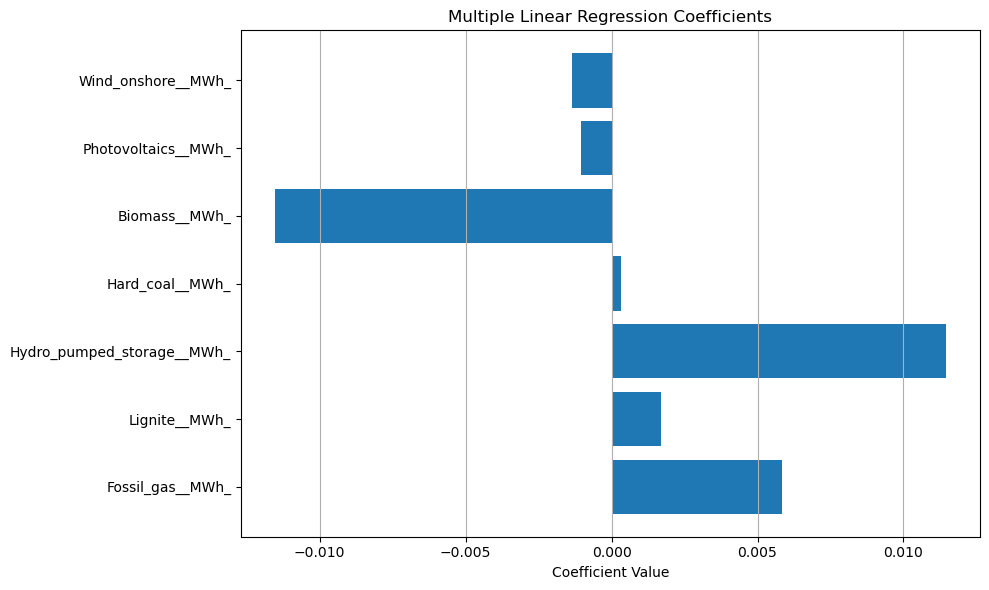

In [10]:
# Visualize the coefficients of the linear regression model
# Bar Plot of Regression Coefficients
coef = linear_model.coef_
intercept = linear_model.intercept_
print("Intercept:", intercept)
print("Coefficients:", coef)
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, coef)
plt.xlabel('Coefficient Value')
plt.title('Multiple Linear Regression Coefficients')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [11]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create a Random Forest model with default parameters
rf_model = RandomForestRegressor(random_state=42) 
rf_model.fit(X_train, y_train)

# Print the RMSE and MAE for the training set
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
display_error_metrics(y_train, y_train_pred, y_val, y_val_pred, "Random Forest", "Validation")


# Tune the Random Forest model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)
# Get the best parameters from the grid search
best_rf_params = rf_grid_search.best_params_
print("Best Random Forest Parameters:", best_rf_params)

# Create and fit the Random Forest model
rf_model_final = RandomForestRegressor(n_estimators=best_rf_params.get('n_estimators'),max_depth=best_rf_params.get('max_depth'),
                                 min_samples_split=best_rf_params.get('min_samples_split'), random_state=42)
rf_model_final.fit(X_train, y_train)

# Print the RMSE and MAE for the training set
y_train_pred = rf_model_final.predict(X_train)
y_test_pred = rf_model_final.predict(X_test)
display_error_metrics(y_train, y_train_pred, y_test, y_test_pred, "Random Forest")

# Save the model to file using pickle
os.makedirs('outputs', exist_ok=True) # Create the 'outputs' folder if it doesn't
with open('outputs/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model_final, f)


Random Forest Error Metrics:
Training Data Error : {'MAE': 3.83, 'RMSE': 6.54}
Validation Error : {'MAE': 10.03, 'RMSE': 14.66}
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Error Metrics:
Training Data Error : {'MAE': 4.46, 'RMSE': 8.03}
Test Error : {'MAE': 9.64, 'RMSE': 14.67}


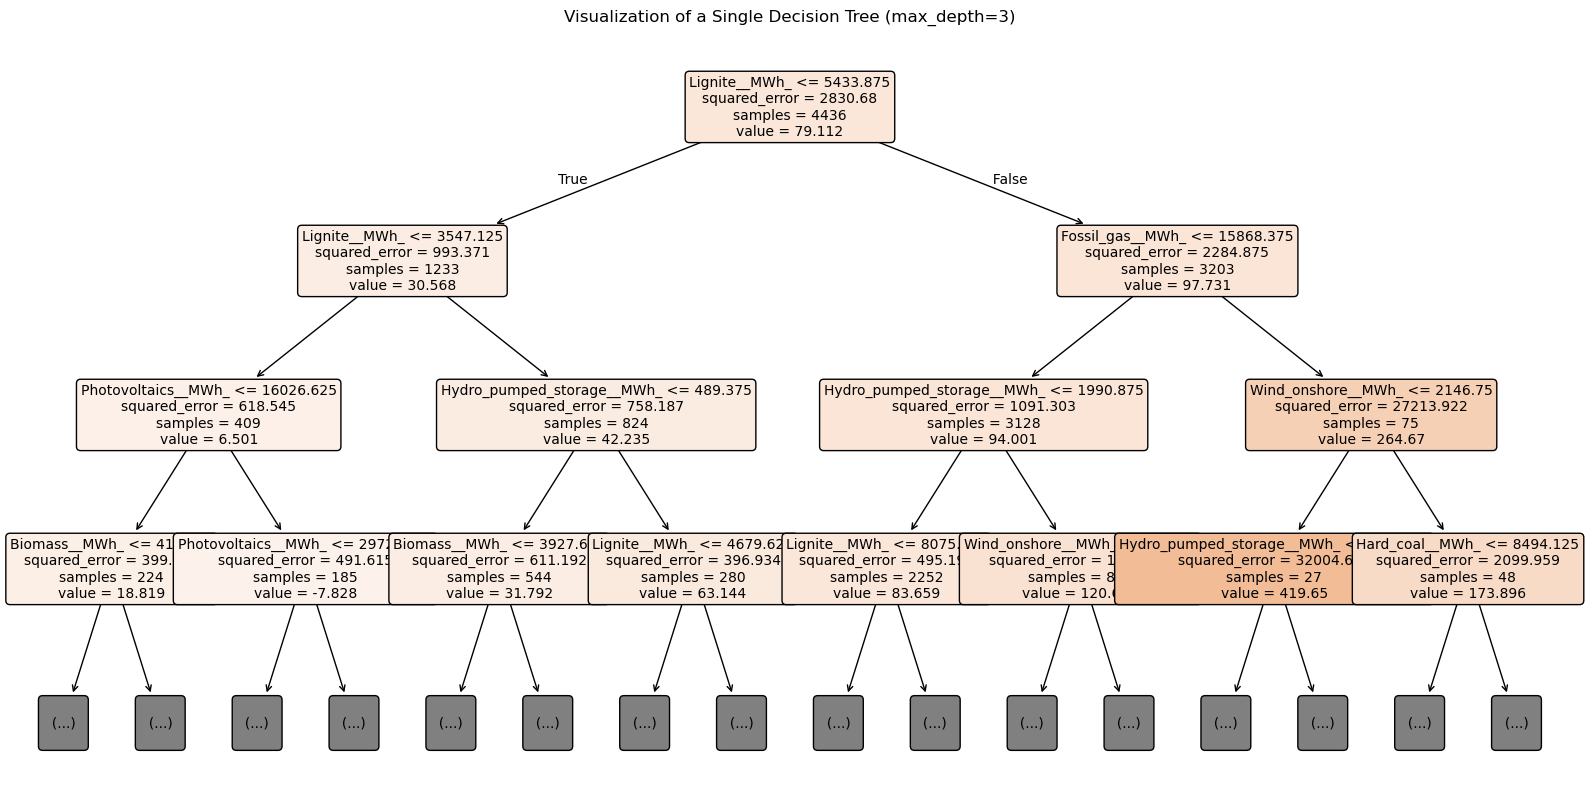

In [12]:
# Visualize a single tree from the Random Forest
from sklearn.tree import plot_tree

# Pick one tree from the trained Random Forest
estimator = rf_model_final.estimators_[0]  # First tree in the forest

plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3, fontsize=10)
plt.title('Visualization of a Single Decision Tree (max_depth=3)')
plt.show()

In [13]:
# Train LightGBM model
from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

# Print the RMSE and MAE for the training set
y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)
display_error_metrics(y_train, y_train_pred, y_val, y_val_pred, "LightGBM", "Validation")

# Print the RMSE and MAE for the training set
y_test_pred = lgbm_model.predict(X_test)
display_error_metrics(y_train, y_train_pred, y_test, y_test_pred, "LightGBM")

# Save the model to file using pickle
os.makedirs('outputs', exist_ok=True) # Create the 'outputs' folder if it doesn't
with open('outputs/lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 7027, number of used features: 7
[LightGBM] [Info] Start training from score 78.539586
LightGBM Error Metrics:
Training Data Error : {'MAE': 8.77, 'RMSE': 12.82}
Validation Error : {'MAE': 10.87, 'RMSE': 15.35}
LightGBM Error Metrics:
Training Data Error : {'MAE': 8.77, 'RMSE': 12.82}
Test Error : {'MAE': 10.92, 'RMSE': 15.24}


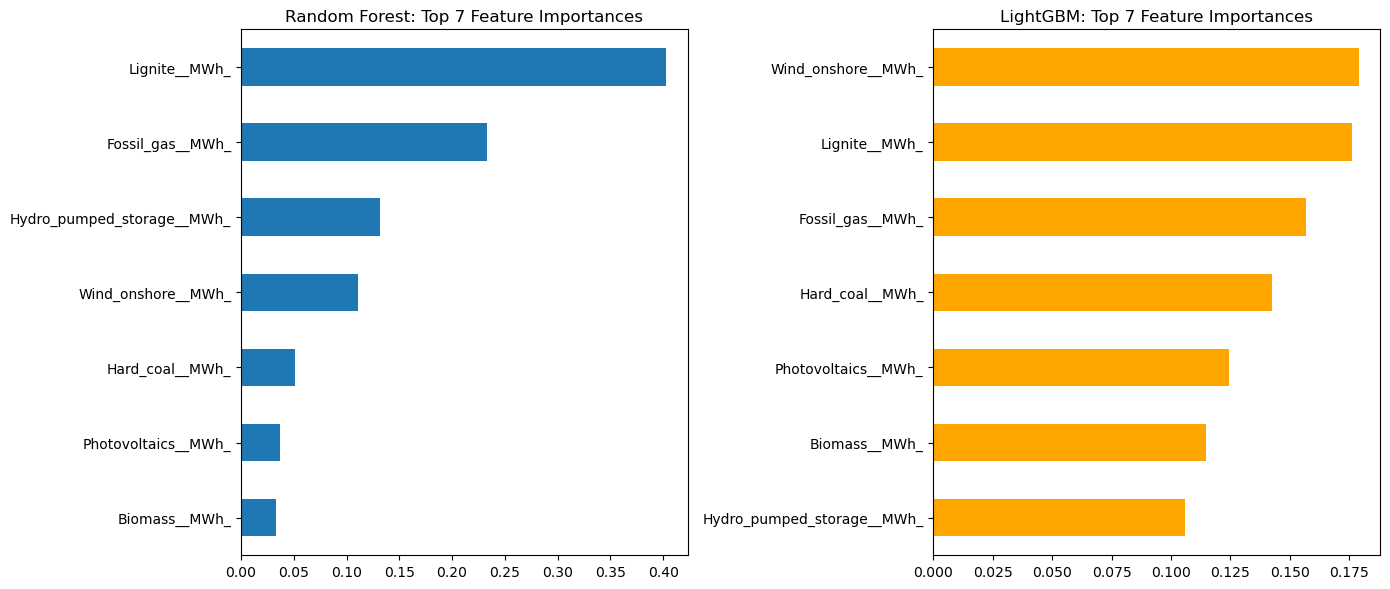

In [14]:
# Ensure you have the feature names
feature_names = X_train.columns

# --- Random Forest Feature Importance ---
rf_importances = pd.Series(rf_model_final.feature_importances_, index=feature_names).sort_values(ascending=False)

# --- LightGBM Feature Importance ---
gbm_importances = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_names
)
gbm_importances = (gbm_importances / gbm_importances.sum()).sort_values(ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
rf_importances.head(10).plot(kind='barh', ax=axes[0])
axes[0].set_title("Random Forest: Top 7 Feature Importances")
axes[0].invert_yaxis()

# LightGBM
gbm_importances.head(10).plot(kind='barh', color='orange', ax=axes[1])
axes[1].set_title("LightGBM: Top 7 Feature Importances")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

Part 2
- We are now loading and processing a new dataset from April 2025 (1 month).
- This dataset will be used to forecast electricity prices, which will then be used to perform battery scheduling using the forecasted prices.
- Next, we will use the charging and discharging schedule generated by the optimizer and apply it to the actual (real) prices to calculate the profit.
- We will also calculate the profit that would have been obtained if the forecasted prices had exactly matched the real prices.
- Finally, we will compare both profits to determine the sensitivity of the system .

In [ ]:
# Load the datasets
year_month = '2025_04'
generation = 'Actual_generation_'+ year_month + '.csv'
consumption = 'Actual_consumption_'+ year_month + '.csv'
day_ahead = 'Day-ahead_prices_'+ year_month + '.csv'
generation_data_2025 = pd.read_csv('inputs/' + generation, sep=';')
consumption_data_2025 = pd.read_csv('inputs/' + consumption, sep=';')
day_ahead_data_2025 = pd.read_csv('inputs/' + day_ahead, sep=';')

# Rename columns for clarity
cols_to_rename = [
    'Biomass', 'Hydropower', 'Wind offshore', 'Wind onshore',
    'Photovoltaics', 'Fossil gas', 'Other renewable', 'Hard coal',
    'Lignite', 'Hydro pumped storage', 'Other conventional']
generation_data_2025.rename(columns={
    f"{col} [MWh] Calculated resolutions": f"{col} [MWh]"
    for col in cols_to_rename
}, inplace=True)

generation_data_2025.drop(columns=['Start date', 'End date','Nuclear [MWh] Calculated resolutions'], inplace=True)

# Merge the datasets based on the 'Start date' column
df = pd.DataFrame()
df['Start date'] = pd.to_datetime(consumption_data_2025['Start date'], format='%b %d, %Y %I:%M %p')
df['day_ahead_price [Euro/MWh]'] = day_ahead_data_2025['Germany/Luxembourg [€/MWh] Original resolutions']
df['grid_load [MWh]'] = consumption_data_2025['grid load [MWh] Calculated resolutions']
df = pd.concat([df, generation_data_2025], axis=1)

# Convert specific columns to float
cols_to_convert = df.columns.drop('Start date')
df[cols_to_convert] = df[cols_to_convert].replace('-', 0, regex=True)
df[cols_to_convert] = df[cols_to_convert].replace(',', '', regex=True).astype(float)

df.columns = df.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
print(df.columns)  # Display the DataFrame

Index(['Start_date', 'day_ahead_price__Euro_MWh_', 'grid_load__MWh_',
       'Biomass__MWh_', 'Hydropower__MWh_', 'Wind_offshore__MWh_',
       'Wind_onshore__MWh_', 'Photovoltaics__MWh_', 'Other_renewable__MWh_',
       'Lignite__MWh_', 'Hard_coal__MWh_', 'Fossil_gas__MWh_',
       'Hydro_pumped_storage__MWh_', 'Other_conventional__MWh_'],
      dtype='object')


The LGBM model was chosen due to its strong generalization ability and competitive performance in terms of error metrics.

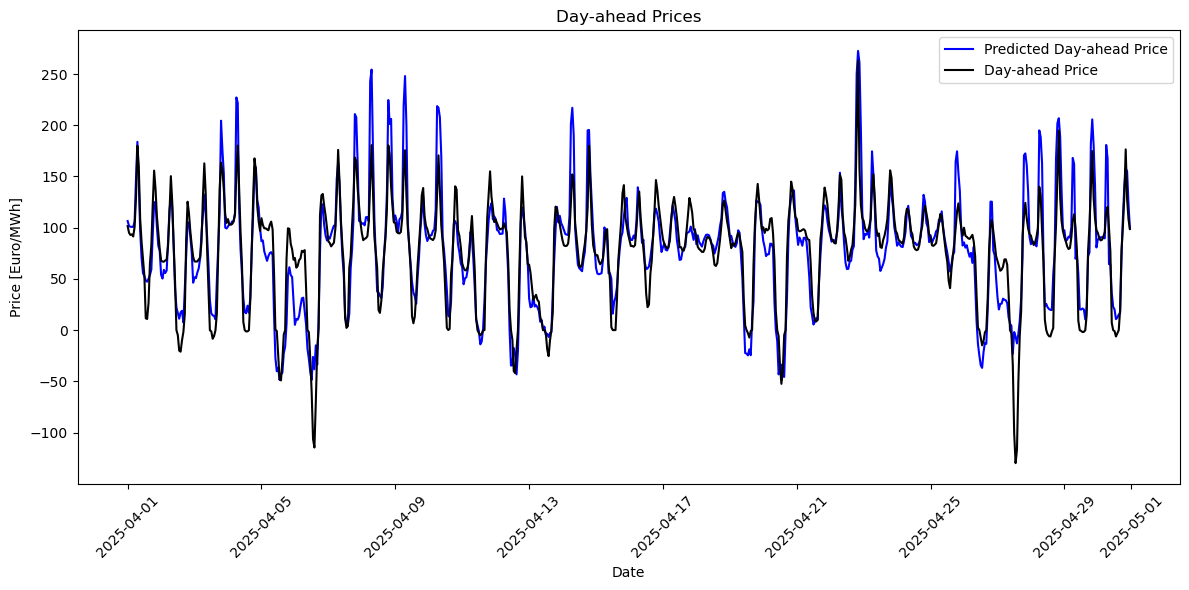

                 Time       price  price_original
0 2025-04-01 00:00:00  106.492960          101.56
1 2025-04-01 01:00:00  101.760169           95.02
2 2025-04-01 02:00:00  100.852677           92.91
3 2025-04-01 03:00:00  100.852677           93.50
4 2025-04-01 04:00:00  100.713969           91.43


In [22]:
# Load the best model (LightGBM) from the saved file
with open('outputs/lgbm_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Predict the day-ahead prices using the Best model
X_real_data = df[top_features.drop('day_ahead_price__Euro_MWh_')]
y_real_data = df['day_ahead_price__Euro_MWh_']
predicted_prices = best_model.predict(X_real_data)

# Add the predicted prices to the DataFrame
df_new = pd.DataFrame()
df_new['Time'] = df['Start_date']
df_new['price'] = predicted_prices
df_new['price_original'] = y_real_data

# Plot the day-ahead prices over time
plt.figure(figsize=(12, 6))
plt.plot(df_new['Time'], df_new['price'], label='Predicted Day-ahead Price', color='blue')
plt.plot(df_new['Time'], df_new['price_original'], label='Day-ahead Price', color='black')
plt.xlabel('Date')
plt.ylabel('Price [Euro/MWh]')
plt.title('Day-ahead Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(df_new.head())

In [ ]:
# Function to calculate profit from the real prices and the Charging and Discharging cycles from the optimization for the predicted prices
def cal_profit(price_df, results_df):
    """
    Calculate profit based on price data and results DataFrame.
    
    Parameters:
    - price_df: DataFrame containing price data with 'price' column.
    - results_df: DataFrame containing results with 'dispatch' column.
    
    Returns:
    - profit: Total profit calculated from the results.
    """
    # Ensure the price_df has a 'price' column
    if 'price_original' not in price_df.columns:
        raise ValueError("price_df must contain a 'price_original' column.")
    
    # Calculate profit
    results_df['price_original'] = price_df['price_original']
    results_df['profit_original'] = ((results_df['P_dis'] - results_df['P_ch']) * price_df['price_original'])

    # Calculate total profit
    total_profit = results_df['profit'].sum() / 1000  # Convert to k€
    total_profit_original = results_df['profit_original'].sum() / 1000  # Convert to k€

    # Print results
    print("Dispatch results (head):")
    print(results_df.head())
    print(f"\nTotal profit: {total_profit:.2f} k€")  
    return results_df, total_profit, total_profit_original

In [ ]:
# Run the optimization function with the forcasted price data
from opt_func import optimization_func

print("Running optimization with forecasted prices...")
results_df = optimization_func(df_new, storage_params=None)
results_df,total_profit, total_profit_original = cal_profit(df_new, results_df)
print(f"Total Profit from Original Prices: {total_profit_original:.2f} k€")
results_df['Time'] = df_new['Time']

# Save the results to a CSV file
os.makedirs('outputs', exist_ok=True)  # Create the 'outputs' folder if it doesn't exist
results_df.to_csv('outputs/optimization_results.csv', index=False)


Running optimization with forecasted prices...
Dispatch results (head):
        P_ch  P_dis      E       price       profit
0  -0.000000    0.0    0.0  106.492960     0.000000
1  -0.000000    0.0    0.0  101.760169     0.000000
2   5.263158    0.0    5.0  100.852677  -530.803564
3  50.000000    0.0   52.5  100.852677 -5042.633857
4  50.000000    0.0  100.0  100.713969 -5035.698444

Total profit: 507.58 k€
Dispatch results (head):
        P_ch  P_dis      E       price       profit  price_original  \
0  -0.000000    0.0    0.0  106.492960     0.000000          101.56   
1  -0.000000    0.0    0.0  101.760169     0.000000           95.02   
2   5.263158    0.0    5.0  100.852677  -530.803564           92.91   
3  50.000000    0.0   52.5  100.852677 -5042.633857           93.50   
4  50.000000    0.0  100.0  100.713969 -5035.698444           91.43   

   profit_original  
0              0.0  
1              0.0  
2           -489.0  
3          -4675.0  
4          -4571.5  

Total profit

- Total Profit refers to the profit that was maximized by the optimization function using the forecasted prices.

- Total Profit from Original Prices is the profit obtained by applying the same charge/discharge schedule (generated by the optimization function) to the actual prices.

In [25]:
df_actual = pd.DataFrame()
df_actual['Time'] = df['Start_date']
df_actual['price'] = y_real_data
print(df_actual.head())

results_df_actual = optimization_func(df_actual, storage_params=None)
results_df_actual['Time'] = df_actual['Time']
total_profit_actual = results_df_actual['profit'].sum()/ 1000  # Convert to k€
print(f"Total Profit from Actual Prices: {total_profit_actual:.2f} k€")

                 Time   price
0 2025-04-01 00:00:00  101.56
1 2025-04-01 01:00:00   95.02
2 2025-04-01 02:00:00   92.91
3 2025-04-01 03:00:00   93.50
4 2025-04-01 04:00:00   91.43
Dispatch results (head):
        P_ch  P_dis      E   price       profit
0  -0.000000    0.0    0.0  101.56     0.000000
1   0.000000    0.0   -0.0   95.02     0.000000
2  50.000000    0.0   47.5   92.91 -4645.500000
3   5.263158    0.0   52.5   93.50  -492.105263
4  50.000000    0.0  100.0   91.43 -4571.500000

Total profit: 487.46 k€
Total Profit from Actual Prices: 487.46 k€


Total Profit from Actual Prices represents the profit that would have been achieved if the forecasted prices had exactly matched the actual prices

In [26]:
# Calculate RMSE and Sensitivity Analysis
rmse_final = np.sqrt(mean_squared_error(results_df['price'], results_df['price_original']))
print(f"RMSE: {rmse_final:.2f} €/MWh")

Sensitivity = (total_profit_actual - total_profit_original) * 1000 / rmse_final
print(f"Sensitivity: {Sensitivity:.2f} € per €/MWh RMSE")

RMSE: 24.60 €/MWh
Sensitivity: 2573.83 € per €/MWh RMSE
